In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
from copy import deepcopy
import CBcm

In [2]:
from scipy import stats

import iminuit

In [3]:
sys.path.append('/home/jp/projects/atm_nu/mceq_tysak/muon_fit/modules')

In [4]:
physics_params = ['le_pi+','le_pi-','le_K+','le_K-',
                  #'le_p','le_n',

                  'he_pi+','he_pi-', 'he_K+','he_K-',
                   'he_p','he_n',
                  
                  'vhe1_pi+', 'vhe1_pi-', 
                  #'vhe1_K+','vhe1_K-',
                   #'vhe1_p','vhe1_n',
                  
                  #'vhe2_pi+', 'vhe2_pi-', 
                  #'vhe2_K+','vhe2_K-',
                  # 'vhe2_p','vhe2_n',
                  
                  'vhe3_pi+', 'vhe3_pi-', 
                  'vhe3_K+','vhe3_K-',
                   'vhe3_p','vhe3_n',
                  #'scale',

                   'GSF_1','GSF_2',
                   'GSF_3','GSF_4',
                   'GSF_5','GSF_6']

In [5]:
import mufit
reload(mufit)
import mufit_plots as mfp
reload(mfp)

MUFIT: Using quickflux2!
MUFIT: Using quickflux2!
MufitPlots does not use the mceq flux evaluator directly
MufitPlots does not use the mceq flux evaluator directly


<module 'mufit_plots' from '/home/jp/projects/atm_nu/mceq_tysak/muon_fit/modules/mufit_plots.pyc'>

In [6]:
fitname = 'prd22_qf2_v19_var'
filename = '/home/jp/projects/atm_nu/ddm_results/'+fitname+'.pkl'


In [7]:
fit = mufit.MuFit(datasets = ['bess',
                              'l3c', 
                              'opera', 
                              'minos',
                              'cms',
                              'deis',
                              'mutronratio',
                             'deisratio'],
                  vhe_relations = {},
                 flux_splines = 'ddmgsf-v19',)


/home/jp/projects/atm_nu/mceq_tysak/muon_fit/modules/resources/DDM_splines_20221115_newstyle_smarter.pkl
Excluded params removed from known_params.
No calibration file for ddmgsf-v19
Adjusting DEIS name
ddmgsf-v19
('Using errors in mode: ', 'mixed')
MUTRON ratio: adding ALL errors in quadrature
DEIS ratio: adding ALL errors in quadrature


In [11]:
my_flux_parameters = {
            # The fit only has power for GSF_1 and the scale parameter
            'GSF_1': [0., False, -4, 4, 0., 1], 
            'GSF_2': [0., False, -4, 4, 0., 1], 
            'GSF_3': [0., False, -4, 4, 0., 1], 
            'GSF_4': [0., False, -4, 4, 0., 1], 
            'GSF_5': [-1., False, -4, 4, 0., 1], 
            'GSF_6': [0., False, -4, 4, 0., 1], 
            #'scale':[0., True, -4, 4, 0., 0.5], # Don't mention scale at all in new tables

            # LE - sensitivity except K-
            'le_pi+': [0.8, False, -10, 10, 0., 1],
            'le_pi-': [-0., False, -10, 10, 0., 1],
            'le_K+': [0., False, -10, 10, 0., 1], 
            'le_K-': [0., False, -10, 10, 0., 1], 

           
            # HE - sensitivity for all (increased errors for K by 4x)
            'he_pi+': [-0.08, False, -10, 10, 0., 1], 
            'he_pi-': [8, False, -10, 10, 0., 1], 
            'he_K+': [0., False, -10, 10, 0., 1], 
            'he_K-': [0., False, -10, 10, 0., 1], 
            'he_p':[0., False, -10, 10, 0., 1], 
            'he_n':[0., False, -10, 10, 0., 1], 

            # VHE1 - Little power over all, very weak for K+
            'vhe1_pi+':[-0.3, False, -5., 5.,  0.,  2.5], # Verified, power
            'vhe1_pi-':[0,False, -33,  33,    0,  10], # Verified, power
           
            
            # VHE2 - Very little power for K, p and n
            #'vhe2_pi+':[-0, False, -5., 5.,  0.,  3.], # Verified, fit has power
            #'vhe2_pi-':[0, False, -33,  33,    0,   14], # Verified, little power

            # VHE3 - Power for pi-, marginal for everyone else
            'vhe3_pi+':[-0, False, -5., 5.,  0.,  2.], # Verified, NO POWER
            'vhe3_pi-':[0, False, -33,  33,    0,   10], # Verified, little power
            'vhe3_K+': [ 0., False, -19,  19,  0,  10], # Verified, NO POWER
            'vhe3_K-': [0., False, -25,  30, 0.,  20.], # Verified, NO POWER
            'vhe3_p':[0., False, -16, 16,  0., 6], # Verified, NO POWER
            'vhe3_n':[0., False, -6, 6,   0,  2.5], # Verified, NO POWER
        }

In [12]:
mysyst = deepcopy(fit.systematics)
mysyst.update({# Fixing DEIS because errors are included by default
               'deis_mscat':  [0.0, True, -3, 3],
               'deis_bfield':  [0.0, True, -3, 3],
               'deis_norm':  [0.0, True, -3, 3],

               # # Added for testing
#                    'amsratio_mc': 0., # np.random.uniform(-3,3),
#                    'amsratio_statistics':  0., #np.random.uniform(-3,3),
#                    'amsratio_protons':  0., #np.random.uniform(-3,3),

               # L3c (all)
               'l3c_align': 0.0042, #np.random.uniform(-3,3),
               'l3c_bfield': -3.30, #np.random.uniform(-3,3),
               'l3c_eloss': -2.92, #np.random.uniform(-3,3),
               'l3c_overb': -0.5, #np.random.uniform(-3,3),
               'l3c_normHor': -1.41, #np.random.uniform(-3,3),
               'l3c_normVert': -1.591, #np.random.uniform(-3,3),
               'l3c_pres': 1.352, #np.random.uniform(-3,3),

               'mn_escale': -1.59, #np.random.uniform(-3,3),

               # Bess
               'bess_align': -1.72, #np.random.uniform(-3,3),
               'bess_finres': 0.2, #np.random.uniform(-3,3),
               })

In [13]:
nfits = 1
counter = 0
bestfit = 1E9
defprior = 60
for ifit in range(nfits):
    print 'Internal fit ', ifit
    one_m, one_f = fit.run_fit(
        flux_parameters = my_flux_parameters,        
        exp_parameters = mysyst,
        fit_data = 'all',
        fit_mode = 'physics',
        use_priors = True,
        print_mode = False,
        dry_run = False,
        emin=5.,
        fake_data = False,
        )
    
    this_fit = fit.results['fmin']['fval']
    print 'This fit', this_fit
    if this_fit < bestfit:
        print 'Updated results for fit', this_fit, bestfit
        bestfit = deepcopy(this_fit)
        results = deepcopy(fit.results)
        m = one_m
        f = one_f

Internal fit  0
Successful fit!
This fit 499.224894078
Updated results for fit 499.224894078 1000000000.0


In [14]:
free_params = 0
for one_param in fit.fit_keys:
    if not fit.minuit_settings['fix_'+one_param]:
        free_params += 1
#print(free_params, len(fit.fit_keys))

In [15]:
all_keys = results['params'].keys()
dof = fit.results['bins']-free_params
print 'Chi2',fit.results['chi2'], '/', dof, 'dof (approximate)'
p_value = 1-stats.chi2.cdf(fit.results['chi2'], dof)
print('P-value', p_value)
syst_keys = []
print '\t'.join(['Param', 'value','error'])
for one_param in physics_params:
    all_keys.remove(one_param)
    print '\t'.join([one_param, 
                     "%0.2f" % results['params'][one_param]['value'],
                    "%0.2f" % results['params'][one_param]['error']])
all_keys.sort()
for one_param in all_keys:
    print '\t'.join([one_param, 
                     "%0.2f" % results['params'][one_param]['value'],
                    "%0.2f" % results['params'][one_param]['error']])



Chi2 422.0818348849492 / 424 dof (approximate)
('P-value', 0.5171751384368453)
Param	value	error
le_pi+	-0.97	0.78
le_pi-	-1.93	0.38
le_K+	-0.65	0.76
le_K-	-0.05	0.99
he_pi+	-0.06	0.10
he_pi-	3.56	0.71
he_K+	0.26	0.98
he_K-	0.27	0.99
he_p	0.69	0.95
he_n	2.40	0.79
vhe1_pi+	-1.30	0.35
vhe1_pi-	-2.10	2.27
vhe3_pi+	-4.50	1.53
vhe3_pi-	-0.70	7.42
vhe3_K+	4.99	6.74
vhe3_K-	-19.43	12.51
vhe3_p	10.78	5.29
vhe3_n	2.92	2.27
GSF_1	0.82	0.91
GSF_2	0.35	0.99
GSF_3	0.11	0.99
GSF_4	0.56	0.99
GSF_5	-2.05	0.96
GSF_6	0.49	0.98
bess_align	-2.25	0.67
bess_finres	0.20	0.83
deis_bfield	0.00	0.50
deis_mscat	0.00	0.50
deis_norm	0.00	0.50
l3c_align	-0.03	0.07
l3c_bfield	-3.66	0.78
l3c_eloss	-2.84	0.79
l3c_normHor	-1.37	0.55
l3c_normVert	-1.44	0.52
l3c_overb	-0.14	0.50
l3c_pres	1.40	0.48
mn_escale	-1.66	0.32


In [16]:
fit.results['flux_parameters'] = my_flux_parameters

In [17]:
fit.results['flux_tables']

'ddmgsf-v19'

In [18]:
pickle.dump(fit.results, open(filename, 'wb'))
print('Written', filename)

('Written', '/home/jp/projects/atm_nu/ddm_results/prd22_qf2_v19_var.pkl')


In [19]:
m.matrix(correlation=True)

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|              |        he_K-        he_K+       he_pi-       he_pi+       vhe3_n     vhe1_pi+      vhe3_K-      vhe3_K+     vhe1_pi-       vhe3_p       le_pi+       le_pi-        le_K+        le_K-        GSF_4        GSF_5        GSF_6        GSF_1        GSF_2        GSF_3     vhe3_pi+         he_p     vhe3_pi-         he_n   l3c_bfield    l3c_overb    mn_escale   bess_align l3c_normVert  l3c_normHor    l3c_eloss  bess_finres     l3c_pres    l3c_align |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|        he_K- |        1.000        0.017       -0.079        0.046        0.015        0.002       -0.047        0.027       -0.005       -0.001        0.002       -0.001        0.001        0.001       -0.002        0.004        0.001       -0.018       -0.001       -0.000       -0.019       -0.013        0.047       -0.027        0.006       -0.005        0.009        0.015        0.004       -0.001        0.004       -0.003       -0.000        0.004 |
|        he_K+ |        0.017        1.000        0.032       -0.279       -0.028       -0.008        0.091       -0.083        0.002        0.004       -0.014       -0.018       -0.015       -0.000        0.002       -0.004       -0.002       -0.013        0.002        0.000        0.046        0.006       -0.098       -0.014        0.024        0.019       -0.019        0.019        0.008        0.003        0.017        0.002        0.021        0.021 |
|       he_pi- |       -0.079        0.032        1.000        0.725       -0.050        0.279        0.009        0.026        0.283       -0.136        0.082        0.201        0.101        0.020       -0.017        0.055        0.002       -0.282       -0.010       -0.003        0.063       -0.142        0.119       -0.473        0.026       -0.110        0.009        0.165        0.043        0.001        0.007       -0.043       -0.058       -0.026 |
|       he_pi+ |        0.046       -0.279        0.725        1.000       -0.105        0.364       -0.047        0.132        0.492       -0.223        0.048        0.103       -0.041        0.009       -0.004        0.011        0.016       -0.416       -0.001        0.003        0.051       -0.275        0.134       -0.116        0.030       -0.123        0.004        0.187        0.051        0.006        0.010       -0.049       -0.078       -0.032 |
|       vhe3_n |        0.015       -0.028       -0.050       -0.105        1.000       -0.108        0.080       -0.018       -0.358       -0.123        0.036        0.088        0.048        0.004       -0.004        0.018       -0.005       -0.038       -0.003       -0.001        0.063       -0.023       -0.081       -0.115       -0.045       -0.010       -0.011       -0.060       -0.022       -0.012       -0.035        0.006       -0.002       -0.015 |
|     vhe1_pi+ |        0.002       -0.008        0.279        0.364       -0.108        1.000       -0.339       -0.350        0.877       -0.374       -0.003       -0.017        0.015       -0.006        0.000       -0.027       -0.025       -0.642        0.007        0.002       -0.037        0.028        0.

In [20]:
fit.results['cov_params'] = m.list_of_vary_param()
ordered_matrix = np.zeros_like(fit.results['corr_matrix'])
# Need to reorder this business
syst_params = ['l3c_bfield','l3c_overb','l3c_normVert', 'bess_align','bess_finres',
               'l3c_normHor','l3c_eloss','l3c_pres','l3c_align', 'mn_escale']
syst_params.sort()
ordered_phys = np.zeros(len(physics_params))
ordered_syst = np.zeros(len(syst_params))
for ip, one_param in enumerate(physics_params):
    ordered_phys[ip] = fit.results['cov_params'].index(one_param)
for ip, one_param in enumerate(syst_params):
    ordered_syst[ip] = fit.results['cov_params'].index(one_param)
    
full_list = physics_params + syst_params
full_in = np.array(np.concatenate((ordered_phys, ordered_syst)),dtype=int)
for j, one_param in enumerate(full_list):
    for k in range(len(full_in)):
        ordered_matrix[j,k] = fit.results['corr_matrix'][full_in[j], full_in[k]]

In [21]:
if not os.path.exists('/home/jp/projects/atm_nu/ddm_results/'+fitname):
    os.mkdir('/home/jp/projects/atm_nu/ddm_results/'+fitname)

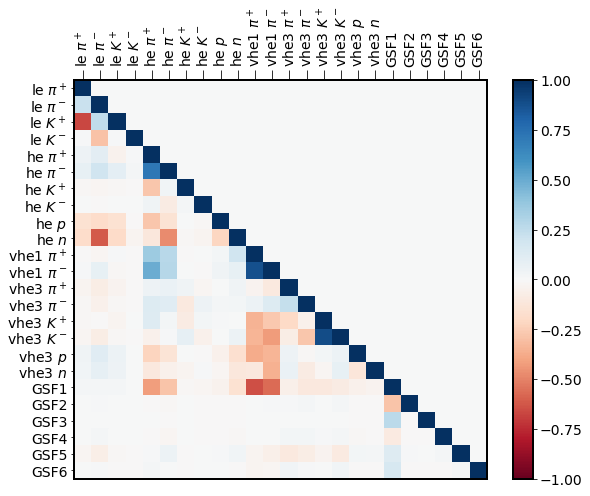

In [22]:
maxb = len(physics_params)
corr_matrix = deepcopy(ordered_matrix)

for i in range(corr_matrix.shape[0]):
    for j in range(corr_matrix.shape[0]):
        if i<j: corr_matrix[i,j]=0.

params = deepcopy(full_list)

# Adjust parameter names
for i, onep in enumerate(params):
    if 'he' in onep or 'K' in onep or 'pi' in onep:
        if 'K+' in onep:
            params[i] = onep.replace('_K+', ' $K^+$')
        elif 'K-' in onep:
            params[i] = onep.replace('_K-', ' $K^-$')
        elif 'pi+' in onep:
            params[i] = onep.replace('_pi+', ' $\pi^+$')
        elif 'pi-' in onep:
            params[i] = onep.replace('_pi-', ' $\pi^-$')
        elif '_p' in params[i]:
            params[i] = onep.replace('_p', ' $p$')
        elif '_n' in params[i]:
            params[i] = onep.replace('_n', ' $n$')    
    elif 'l3c' in params[i]:
        params[i] = 'L3+c ' + params[i].lstrip('l3c_')
    elif 'mn' in params[i]:
        params[i] ='MINOS '  + params[i].lstrip('mn_')
    elif 'bess' in params[i]:
        params[i] = 'BessTeV ' + params[i].lstrip('bess_')
    elif 'GSF' in params[i]:
        params[i] = onep.replace('_', '')
        
    #if 'align' in params[i]:
    #    params[i] = params[i].replace('align','alignment')
    if 'bfield' in params[i]:
       params[i] = params[i].replace('bfield','$B$ field')
    if 'eloss' in params[i]:
       params[i] = params[i].replace('eloss','$E$ loss')
    if 'pres' in params[i]:
       params[i] = params[i].replace('pres','$p_{res}$')
    if 'escale' in params[i]:
       params[i] = params[i].replace('escale','$E$ scale')
    
fig = plt.figure(figsize=(12*0.7,10*0.7))
ax = fig.add_subplot(111)
xmarks = np.arange(0.5, corr_matrix.shape[0], 1.)
plt.pcolor(corr_matrix[:maxb,:maxb], cmap='RdBu', vmin=-1, vmax=1)
plt.xticks(xmarks, params[:maxb], rotation=90)
plt.yticks(xmarks, params[:maxb])
plt.ylim(0,maxb)
plt.xlim(0,maxb)
ax.set_ylim(ax.get_ylim()[::-1])
ax.xaxis.tick_top()
plt.colorbar()
plt.tight_layout()



fig.savefig('/home/jp/projects/atm_nu/ddm_results/'+fitname+'/corr_phys_noscale_qf2.png', dpi=300)
fig.savefig('/home/jp/projects/atm_nu/ddm_results/'+fitname+'/corr_phys_noscale_qf2.pdf')


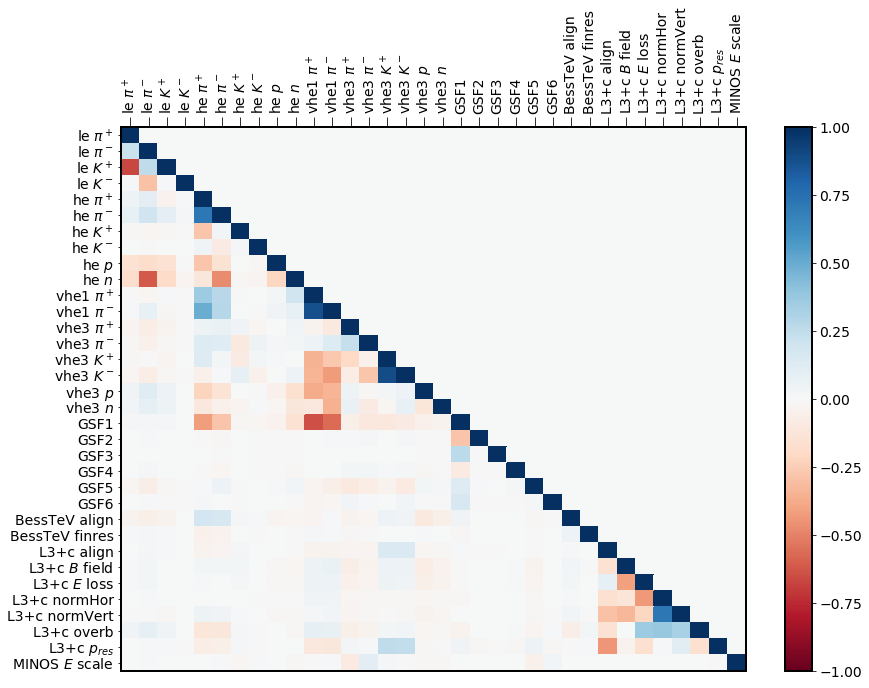

In [23]:
maxb = None
corr_matrix = deepcopy(ordered_matrix)

for i in range(corr_matrix.shape[0]):
    for j in range(corr_matrix.shape[0]):
        if i<j: corr_matrix[i,j]=0.

params = deepcopy(full_list)

# Adjust parameter names
for i, onep in enumerate(params):
    if 'he' in onep or 'K' in onep or 'pi' in onep:
        if 'K+' in onep:
            params[i] = onep.replace('_K+', ' $K^+$')
        elif 'K-' in onep:
            params[i] = onep.replace('_K-', ' $K^-$')
        elif 'pi+' in onep:
            params[i] = onep.replace('_pi+', ' $\pi^+$')
        elif 'pi-' in onep:
            params[i] = onep.replace('_pi-', ' $\pi^-$')
        elif '_p' in params[i]:
            params[i] = onep.replace('_p', ' $p$')
        elif '_n' in params[i]:
            params[i] = onep.replace('_n', ' $n$')    
    elif 'l3c' in params[i]:
        params[i] = 'L3+c ' + params[i].lstrip('l3c_')
    elif 'mn' in params[i]:
        params[i] ='MINOS '  + params[i].lstrip('mn_')
    elif 'bess' in params[i]:
        params[i] = 'BessTeV ' + params[i].lstrip('bess_')
    elif 'GSF' in params[i]:
        params[i] = onep.replace('_', '')
        
    #if 'align' in params[i]:
    #    params[i] = params[i].replace('align','alignment')
    if 'bfield' in params[i]:
       params[i] = params[i].replace('bfield','$B$ field')
    if 'eloss' in params[i]:
       params[i] = params[i].replace('eloss','$E$ loss')
    if 'pres' in params[i]:
       params[i] = params[i].replace('pres','$p_{res}$')
    if 'escale' in params[i]:
       params[i] = params[i].replace('escale','$E$ scale')
    
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111)
xmarks = np.arange(0.5, corr_matrix.shape[0], 1.)
plt.pcolor(corr_matrix[:maxb,:maxb], cmap='RdBu', vmin=-1, vmax=1)
plt.xticks(xmarks, params[:maxb], rotation=90)
plt.yticks(xmarks, params[:maxb])
plt.ylim(0,maxb)
plt.xlim(0,maxb)
ax.set_ylim(ax.get_ylim()[::-1])
ax.xaxis.tick_top()
plt.colorbar()
#fig.savefig('/home/jp/projects/atm_nu/ddm_results/prd22_results_may9_v12_final/corr_full.png', dpi=300)
#fig.savefig('/home/jp/projects/atm_nu/ddm_results/prd22_results_may9_v12_final/corr_full.pdf')


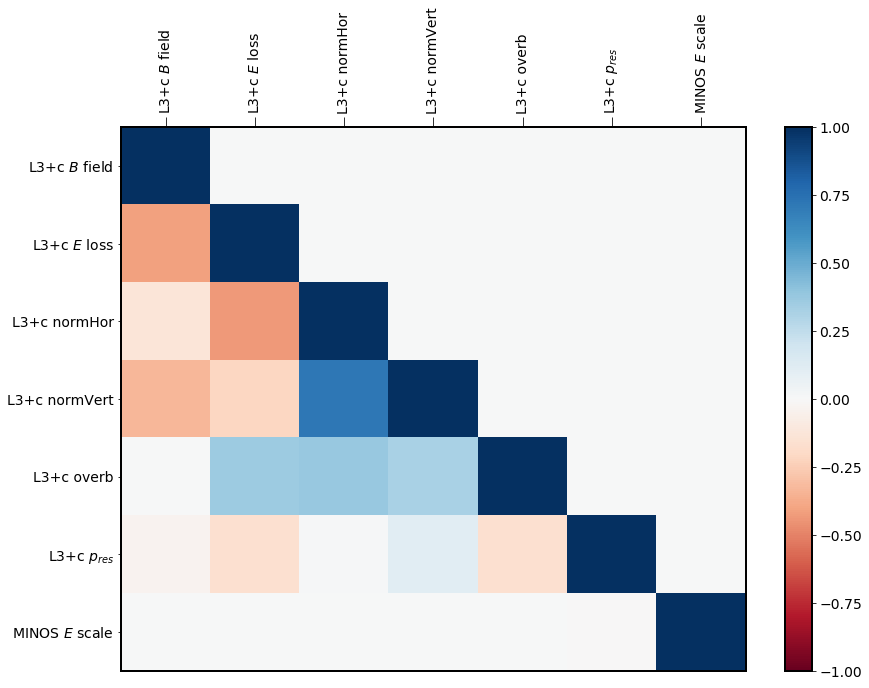

In [24]:
inb = 27
maxb = None
    
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111)
xmarks = np.arange(0.5, corr_matrix[inb:maxb,inb:maxb].shape[0], 1.)
plt.pcolor(corr_matrix[inb:maxb,inb:maxb], cmap='RdBu', vmin=-1, vmax=1)
plt.xticks(xmarks, params[inb:maxb], rotation=90)
plt.yticks(xmarks, params[inb:maxb])
plt.ylim(0,maxb)
plt.xlim(0,maxb)
ax.set_ylim(ax.get_ylim()[::-1])
ax.xaxis.tick_top()
plt.colorbar()
#fig.savefig('/home/jp/projects/atm_nu/ddm_results/prd22_results_may9_v12_final/corr_syst.png', dpi=300)
#fig.savefig('/home/jp/projects/atm_nu/ddm_results/prd22_results_may9_v12_final/corr_syst.pdf')


MufitPlots does not use the mceq flux evaluator directly
Flux deis 87.7076 [3.74461171e-01 5.45162493e-01 2.20595763e+00 9.44369197e+00
 5.12220927e+00 1.12309055e+01 8.78188472e+00 7.30296823e+00
 3.67296468e+00 4.84825740e+00 3.06166820e+00 3.53067347e+00
 7.80590013e-01 3.07550570e-01 9.71507122e-01 2.06732344e-01
 1.42815157e+00 2.39229251e-03 2.15437284e-01 7.37418197e-01
 1.19788827e+00 1.10426071e+00 4.14082394e-02 8.99483618e-01
 1.03981601e-02 1.09556448e-02]


/home/jp/.local/lib/python2.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Flux l3c 38.0475 [ 0.15030117  0.08190555  0.03292154  0.17433084  0.1094358   0.02461852
  0.70236941  0.44725755 12.43823802]
Pull sum 291.88956519363495 130.19525934033206


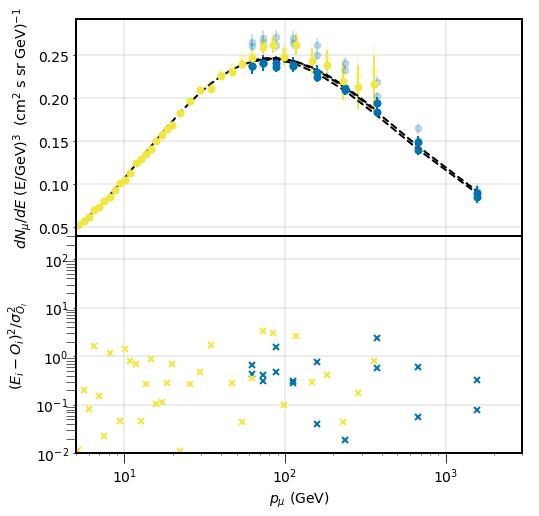

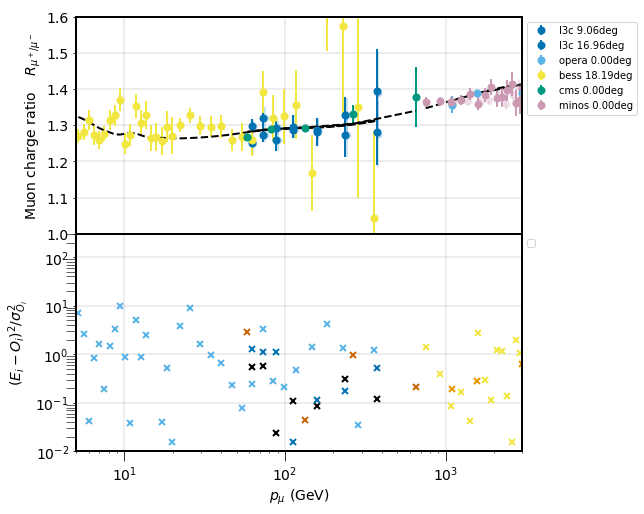

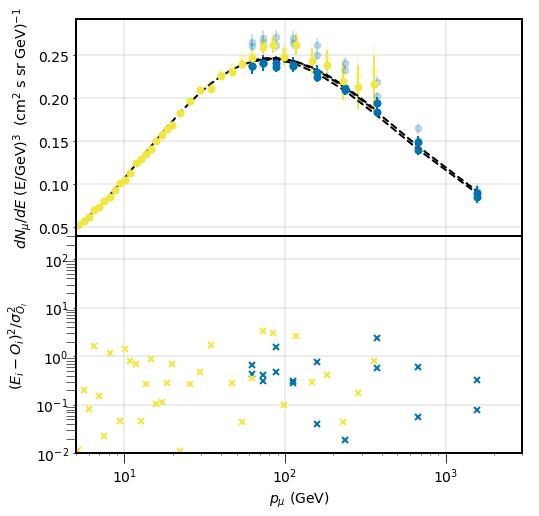

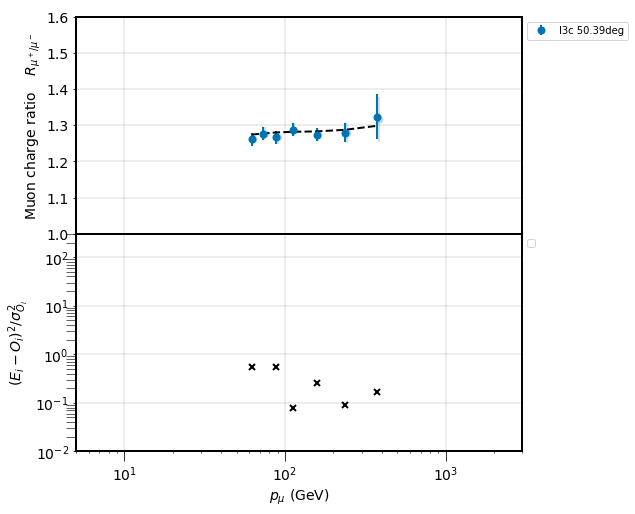

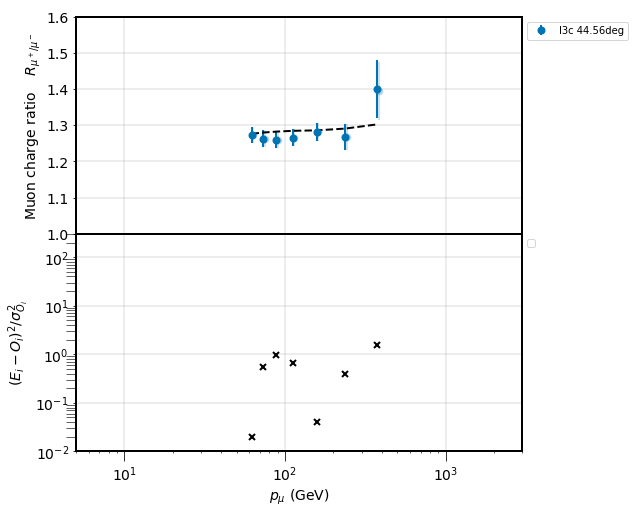

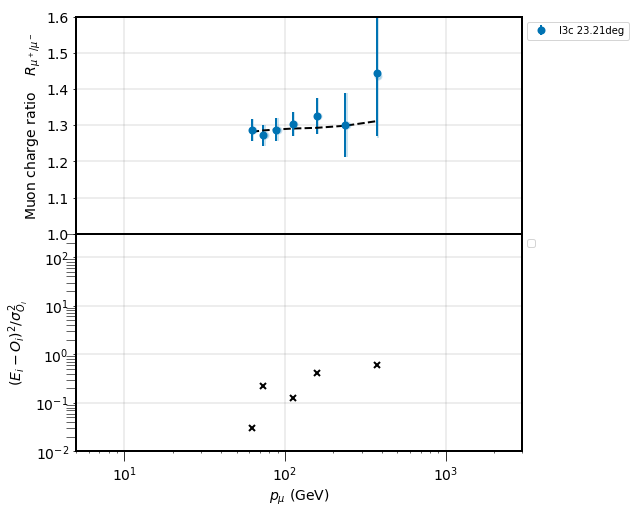

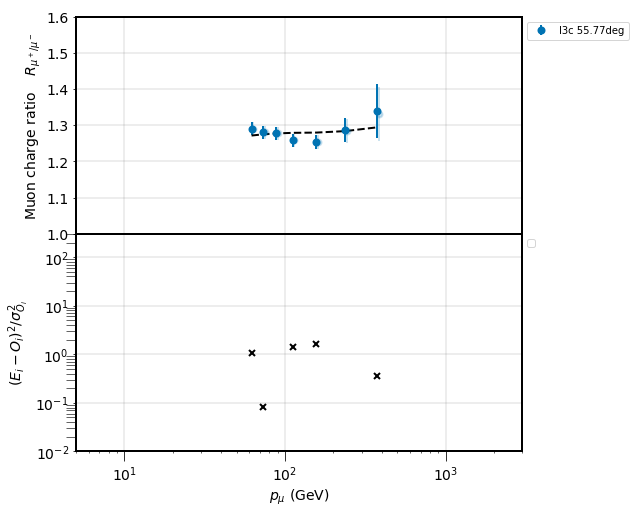

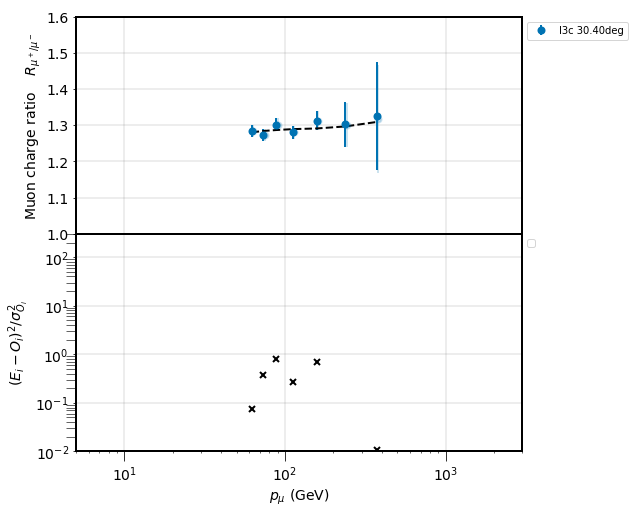

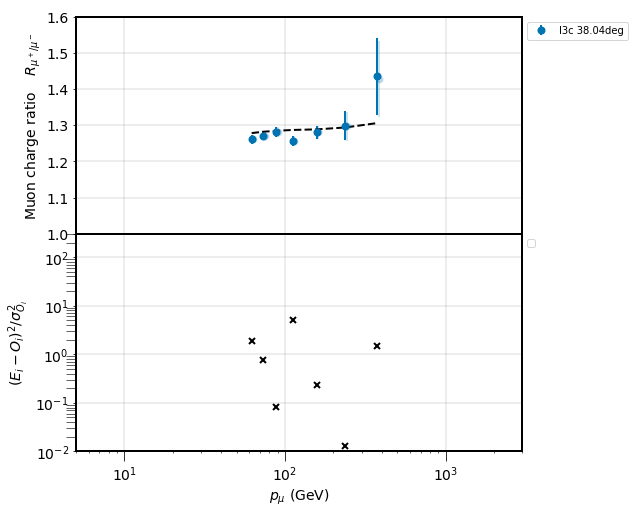

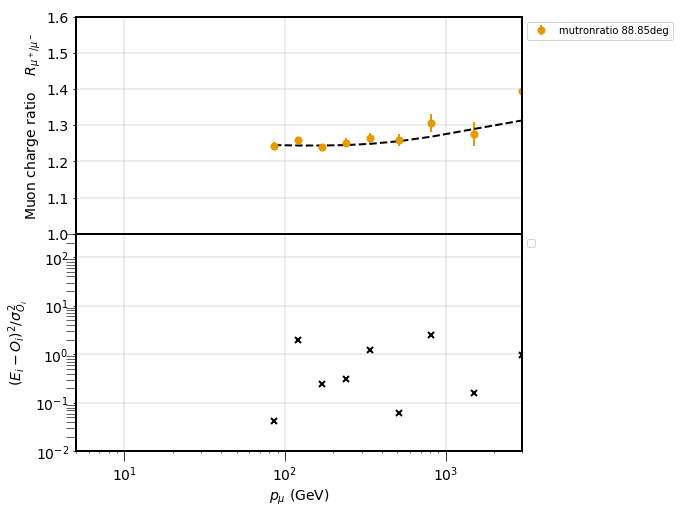

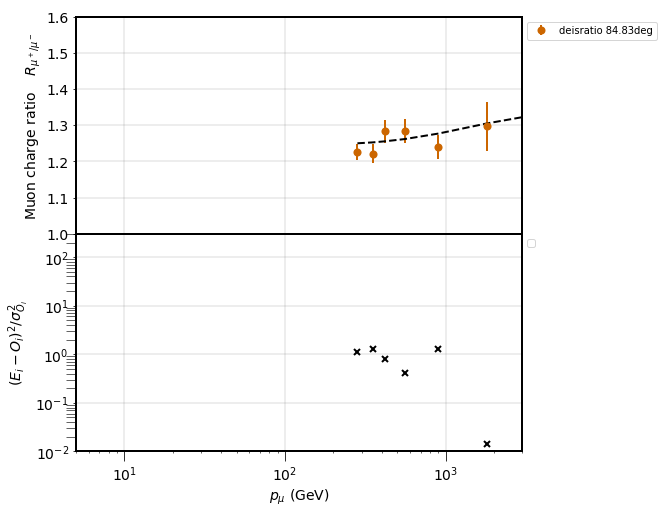

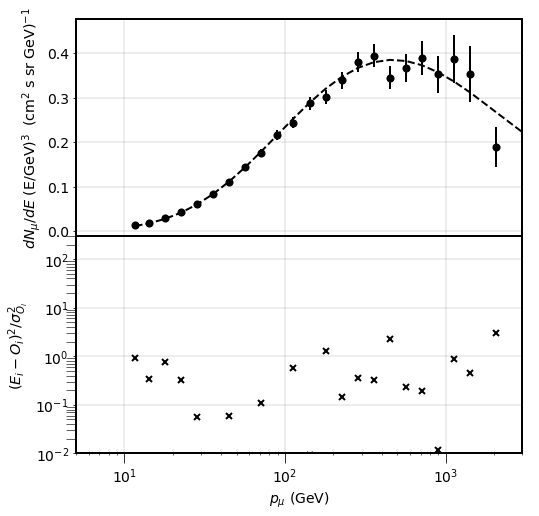

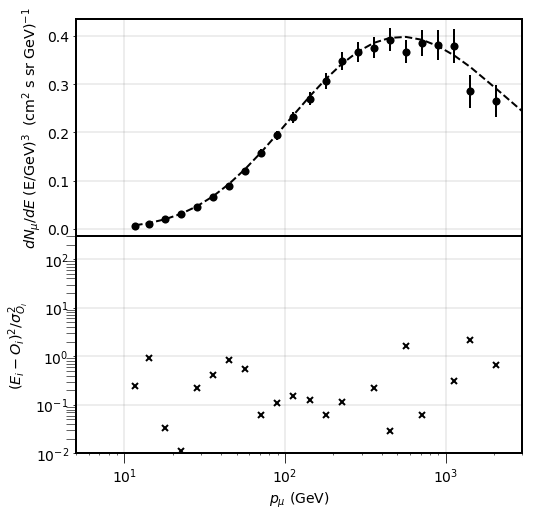

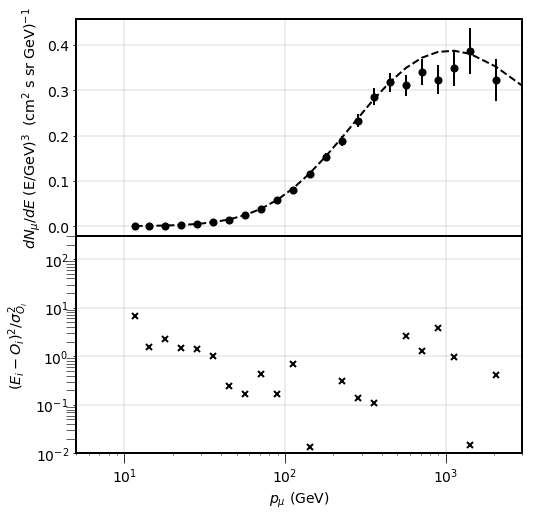

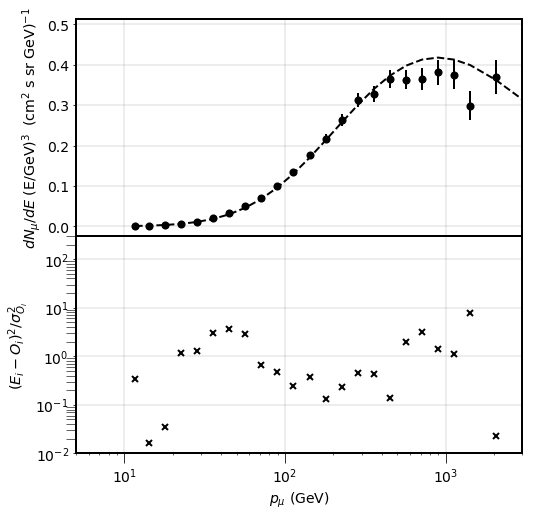

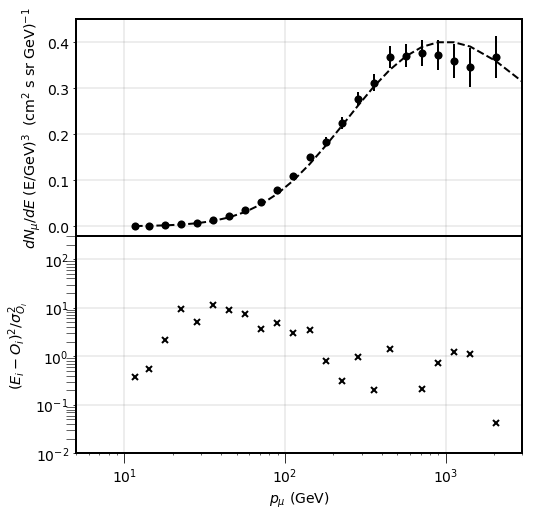

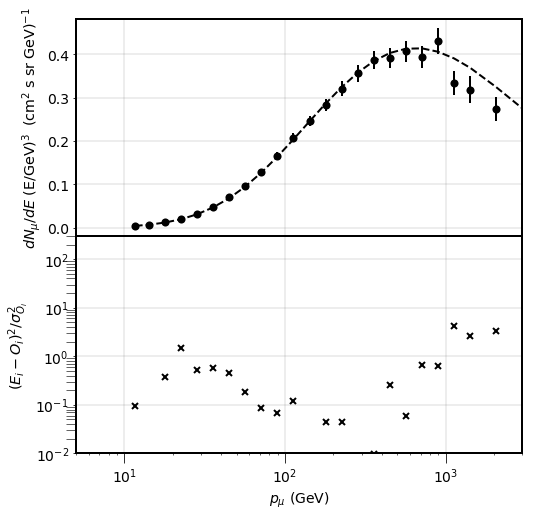

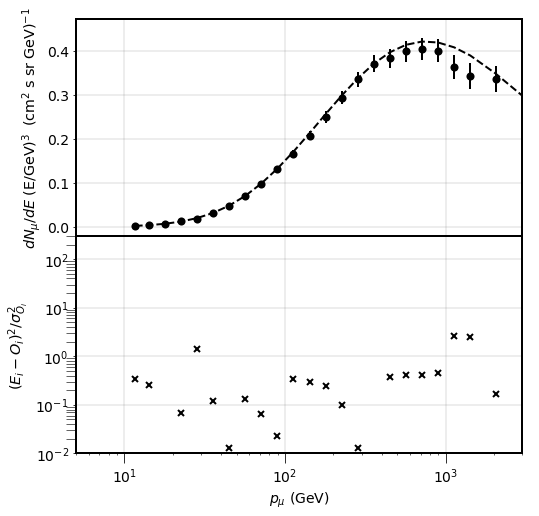

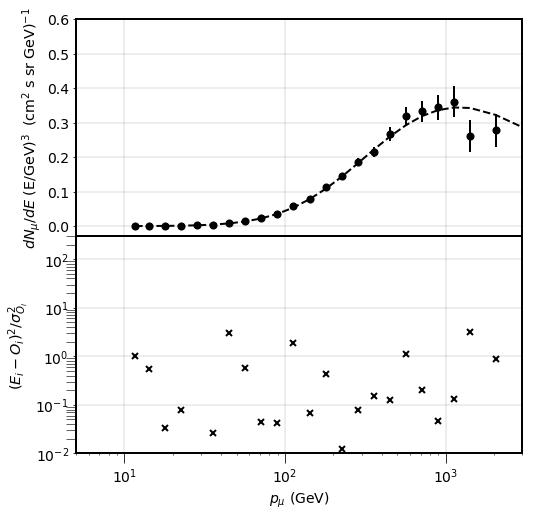

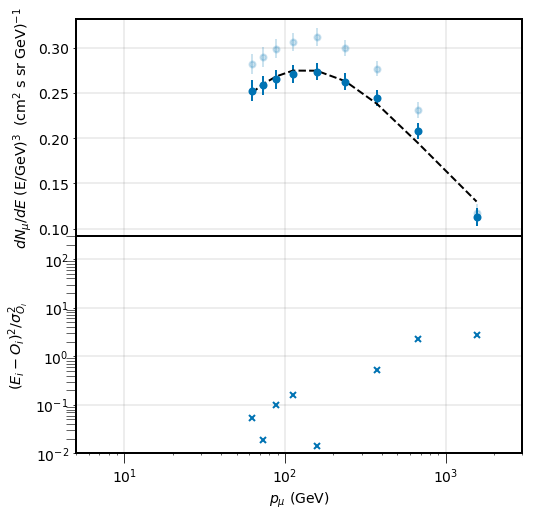

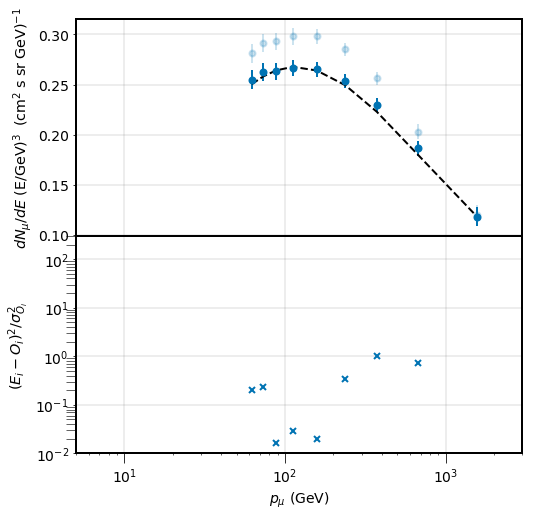

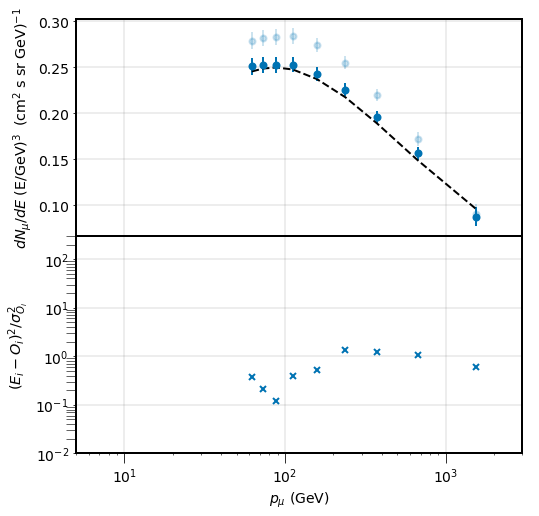

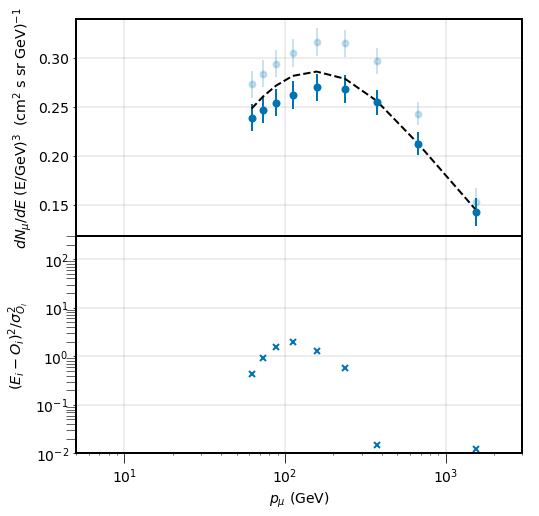

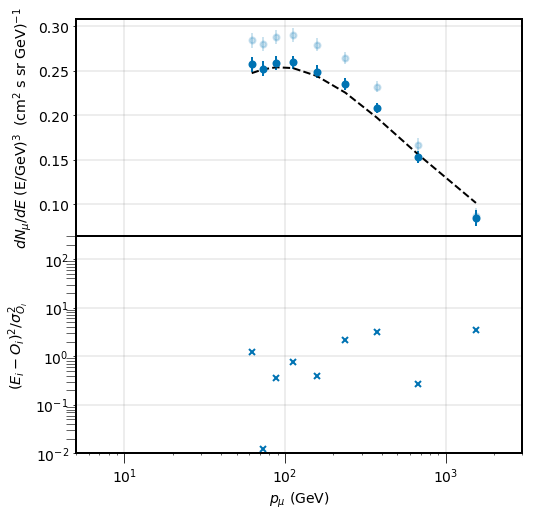

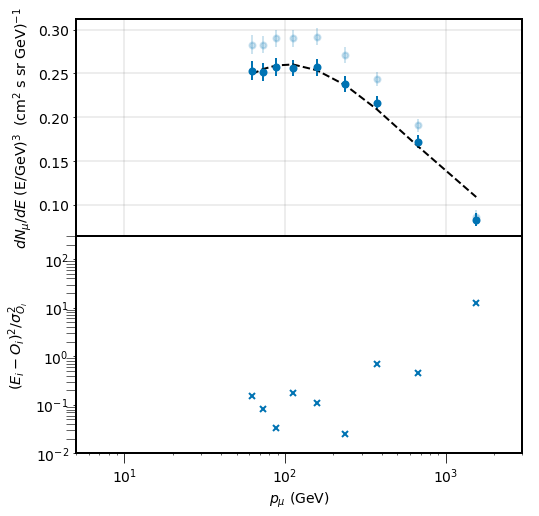

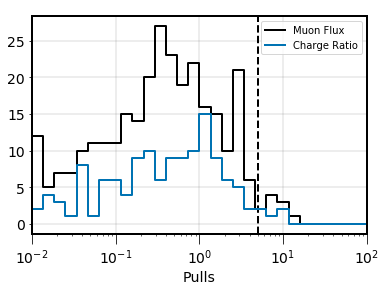

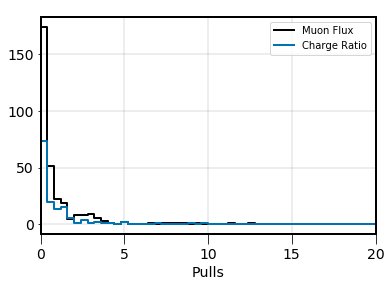

In [25]:
# Plots of the stored fit fluxes, ratios directly - does not evaluate splines again
reload(mfp)
mfp.plot_comparison(fit, pullflag=10.,
                   emin=5)

In [26]:
reload(mfp)

MufitPlots does not use the mceq flux evaluator directly


<module 'mufit_plots' from '/home/jp/projects/atm_nu/mceq_tysak/muon_fit/modules/mufit_plots.pyc'>

 Figure with the following coszen angles [0.   0.05 0.1  0.15 0.55 0.6  0.7  0.75 0.85 0.9  0.95 1.  ]
l3c 50.3943 0.8795464592377784 5
l3c 44.5613 0.7777414039689492 6
l3c 23.2197 0.4052602163253273 9
l3c 55.7711 0.9733893224590094 4
l3c 30.4015 0.5306062725450561 8
l3c 9.0687 0.15827867387560976 11
l3c 16.9617 0.29603751173552223 10
l3c 38.0475 0.6640541471525425 7
bess 18.1949 0.31756091207111625 10


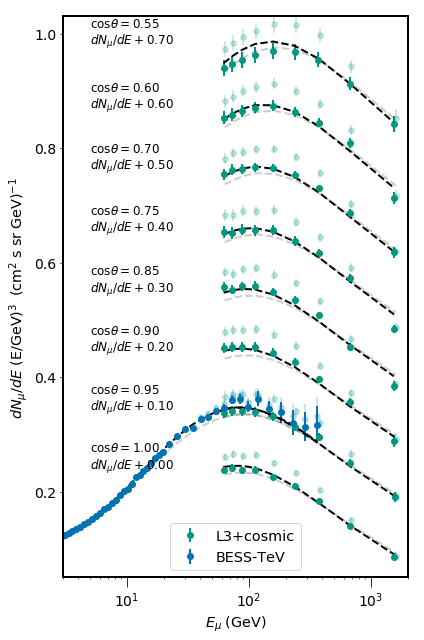

In [27]:
# Plots of the stored fit fluxes, ratios directly - does not evaluate splines again
f1 = mfp.plotICRC21(fit, data_prefit = True)
f1.savefig('/home/jp/projects/atm_nu/ddm_results/muon_results/flux_vert_qf2smart3.pdf')

MufitPlots does not use the mceq flux evaluator directly
 Figure with the following coszen angles [0.   0.05 0.55 0.6  0.7  0.75 0.85 0.9  0.95 1.  ]
l3c 50.3943 0.8795464592377784 3
l3c 44.5613 0.7777414039689492 4
l3c 23.2197 0.4052602163253273 7
l3c 55.7711 0.9733893224590094 2
l3c 30.4015 0.5306062725450561 6
l3c 9.0687 0.15827867387560976 9
l3c 16.9617 0.29603751173552223 8
l3c 38.0475 0.6640541471525425 5
mutronratio 88.8540 1.5507948535670415 0
opera 0.0000 0.0 9
deisratio 84.8364 1.4806745055389174 1
bess 18.1949 0.31756091207111625 8
cms 0.0000 0.0 9
minos 0.0000 0.0 9


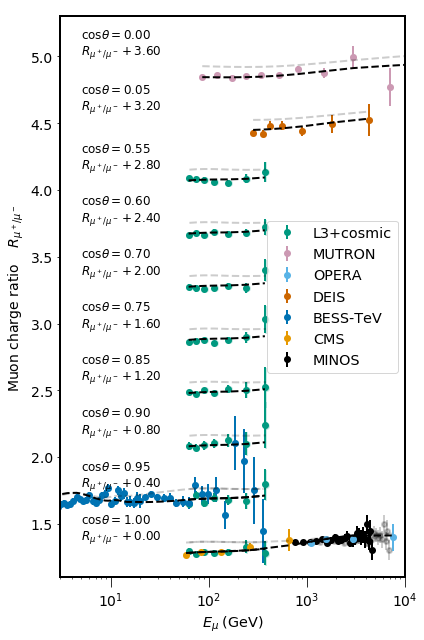

In [28]:
reload(mfp)
f2 = mfp.plotICRC21(fit, data= 'ratio',data_prefit = True)
f2.savefig('/home/jp/projects/atm_nu/ddm_results/muon_results/ratio_vert_qf2smart3.pdf')

MufitPlots does not use the mceq flux evaluator directly
 Figure with the following coszen angles [0.01  0.025 0.035 0.055 0.085 0.115 0.16  0.19  1.   ]
deis 79.0472 0.19000027075775947 7
deis 80.7931 0.16000006510032283 6
deis 89.4270 0.010000569911261043 0
deis 88.2809 0.029999453593602104 1
deis 86.5602 0.059999777566286064 3
deis 87.7076 0.03999925401622205 2
deis 84.8364 0.08999987674362474 4
deis 83.1079 0.11999995530721862 5


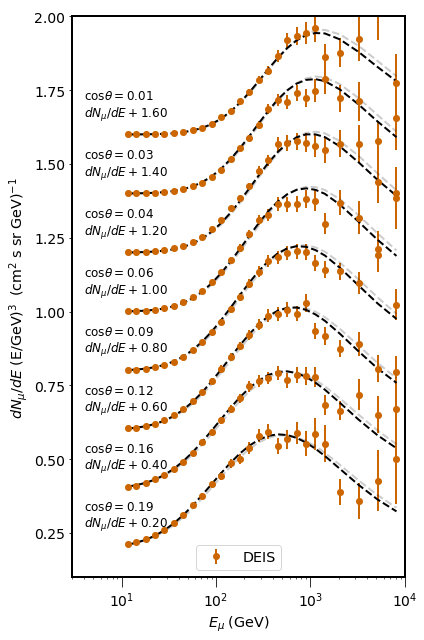

In [29]:
# Plots of the stored fit fluxes, ratios directly - does not evaluate splines again
reload(mfp)
f3 = mfp.plotICRC21(fit, data='deis', data_prefit = True)
f3.savefig('/home/jp/projects/atm_nu/ddm_results/muon_results/flux_deis_qf2smart3.pdf')

MufitPlots does not use the mceq flux evaluator directly


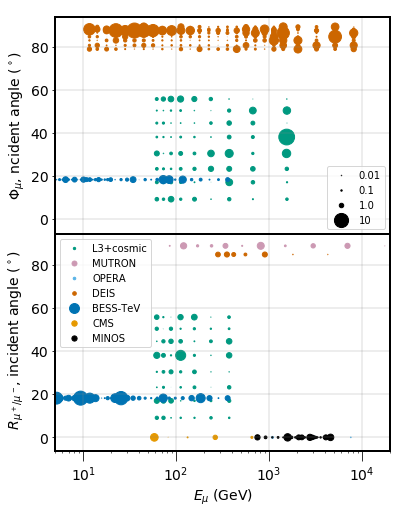

In [30]:
reload(mfp)
f1 = mfp.plotPulls(mufit=fit, pull_scale=20, log_pulls=False
                  )